# Image Classfication
2024-06-20  
by 코어/8기/강대식

## 문제 1-1. VGG16 모델 구현하기

In [1]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

데이터를 준비합니다. 불러온 데이터는 캐글에서 제공되는 개와 고양이의 데이터로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미합니다.  
URL에서 cats_and_dogs.zip 파일을 다운로드하고, 로컬 파일 시스템에 압축을 푼 후, 해당 파일의 경로를 path_to_zip 변수에 저장

In [2]:
# 특정 URL에서 ZIP 파일을 다운로드하고 이를 추출하는 기능을 수행
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) 
# origin=_URL : 파일을 다운로드할 URL (_URL: 미리 정의된 URL)
# extract=True: 다운로드한 zip 파일을 자동으로 추출하도록 설정

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
# train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


train 데이터와 validation 데이터의 개수를 알아봅시다.

In [5]:
#  train_cats_dir 디렉토리 내에 있는 파일의 수를 계산하여 'cats' 클래스의 이미지 파일 개수를 구합니다
# Train
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

# Validation 
num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

# Total
total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


필요한 파라미터를 설정해 줍시다. 파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험을 해보세요.

In [6]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

# # Parameter tuning by 강대식
# batch_size = 16
# epochs = 5
# IMG_HEIGHT = 256
# IMG_WIDTH = 256

이미지를 확인하기 위해 데이터를 시각화하는 함수를 만들어 봅시다.

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr): # 함수 정의 
    fig, axes = plt.subplots(1, 5, figsize=(10,10)) # 1행 5열로 구성된 서브플롯을 생성, 전체 Figure의 크기는 10x10 인치
    axes = axes.flatten()        # axes가 Matplotlib의 서브플롯 Axes 객체 배열이므로, 이를 1차원 배열로 변환
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다.   
range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다.  
우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다.  
Classification task에 따라 class_mode를 변경하시면 됩니다.

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [10]:
# 첫 번째 배치의 입력 데이터의 모양(shape)을 확인
train_data_gen[0][0].shape

(16, 256, 256, 3)

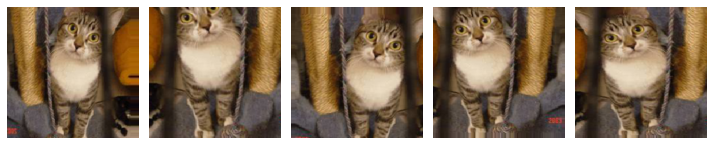

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다.   
그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [12]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [13]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성이 되어 있습니다.

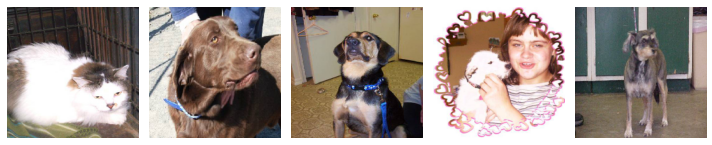

In [14]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [15]:
_[:5] # 정답 데이터

array([0., 1., 1., 1., 1.], dtype=float32)

## 문제 1-1. VGG16 모델 구현하기
이제 VGG16 모델을 구현해 볼 시간입니다. 바로 혼자서 모델을 구현하라고 하면 어렵겠죠? 그래서 참고할만한 모델 구현 코드를 아래에 적어 보았습니다. 실제 VGG16 모델과는 살짝 구조가 다르기 때문에 이미지를 보면서 어느 부분이 다른치 찾아 보는 것도 좋을 것 같습니다.
### 참고 코드

input_layer=tf.keras.layers.Input(shape=(256, 256, 3))  
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)  
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.BatchNormalization()(x)  
x=tf.keras.layers.MaxPool2D((2, 2))(x)  

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.BatchNormalization()(x)  
x=tf.keras.layers.MaxPool2D((2, 2))(x)  

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)  
x=tf.keras.layers.BatchNormalization()(x)  
x=tf.keras.layers.MaxPool2D((2, 2))(x)  

x=tf.keras.layers.Flatten()(x)  
x=tf.keras.layers.Dense(1024, activation='relu')(x)  
x=tf.keras.layers.Dense(512, activation='relu')(x)  
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)  

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])  
model.summary()  

VGG16 모델의 구조를 다시 상기해 보고, 위의 코드를 참고하여 VGG16 모델을 직접 구현해 보세요.  
아래 이미지와 동일하게 VGG16 모델을 구현하려면 GPU 크키가 더 커야할 수도 있습니다.   
구현한 모델을 학습시키다가 커널이 죽을 경우에는 모델 사이즈를 작게 수정해 보세요.
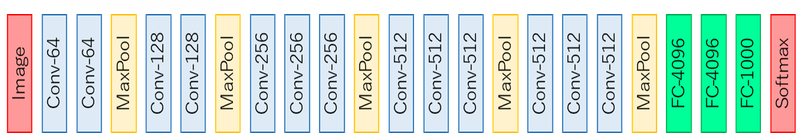

In [16]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.  
# [[YOUR CODE]]
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

In [17]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [18]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[32768,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model/dense/MatMul_1 (defined at tmp/ipykernel_497/1746722190.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2461]

Function call stack:
train_function


In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 문제 1-2. hyperparameter 설정
# [[YOUR CODE]]
# parameter Initialization
batch_size = 32  # origin: 16
epochs = 20  # 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
# 문제 1-2. 데이터 generator 생성
# [[YOUR CODE]]
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [ ]:
# 문제 1-2. 모델 구현
# [[YOUR CODE]]
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(1000, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x) # sigmoid

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

In [ ]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
# [[YOUR CODE]]
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True) # SGD , momentum=0.9, nesterov=True/Adam 50% epoch 4 0.01
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [ ]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()